
# Introduction to Logistic Regression

---

### Learning Objectives
- Understand how logistic regression is similar to and different than regression
- Understand the math behind the logit link function (and logistic function)
- Code the calculation of the odds ratio and log-odds ratio
- Understand how to interpret the coefficients of logistic regression
- Know the benefits of logistic regression as a classifier



<a id='introduction'></a>

## Introduction

---

Logistic regression is a famous classifier still used frequently today, despite its age. It _is_ a regression, but don't let that confuse you: it operates as a classifier. It estimates probabilities of class membership.

In this lecture we will only be reviewing the binary outcome case with two classes, but logistic regression can be generalized to multiple classes.



**Some examples of when logistic regression could be used:**
- Predict whether or not a user will purchase a product given their demographic characteristics.
- Predict the likelihood of a student being admitted to a college, given their scores and the characteristics of the college.
- Diagnose a patient with a disease or not, given symptoms.
- Predict whether a person will default on a loan and with what likelihood.

And many more. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

plt.style.use('ggplot')

%matplotlib inline


from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as sm

/Users/phillippa/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Some nice colors we can use in our plots:
colors = {'blue': '#729ECE',
          'brown': '#A8786E',
          'green': '#67BF5C',
          'grey': '#A2A2A2',
          'orange': '#FF9E4A',
          'pink': '#ED97CA',
          'purple': '#AD8BC9',
          'red': '#ED665D',
          'teal': '#6DCCDA',
          'yellow': '#CDCC5D'}

<a id='load-data'></a>

## Load the college admissions data

---

As we walk through the inner workings of logistic regression, we will be using some basic college admissions data. The data only has a few columns:
- `admit`: a binary 1-0 variable indicating whether a student was admitted
- `gre`: the student's GRE score
- `gpa`: the student's GPA
- `prestige`: a rating for the applicant's undergrad college's prestige

**Load in the data and do any neccessary cleaning.**

In [3]:
admissions = pd.read_csv('./datasets/admissions.csv')
admissions.head(3)

,admit,gre,gpa,prestige
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0


In [4]:
admissions.isnull().sum()

admit       0
gre         2
gpa         2
prestige    1
dtype: int64

In [5]:
admissions.dropna(inplace=True)

### Artificially increase the signal in the data

We going to focus on looking at admit ~ GPA.  For simplicity, we'll first subset our data just to those with prestige = 1.

The signal for detecting admission in the college data is fairly weak. Too weak for demonstration purposes. Below I not only multiply the dataset by 10x, but add some artificial signal for detecting `admit` to the `gpa` column. 

*Obviously* you would never do this to your real data.

In [6]:
admit = admissions[admissions.prestige == 1]

admit = pd.concat([admit]*10, axis=0)

admit.loc[admit.admit == 1, 'gpa'] += np.random.random(size=admit[admit.admit == 1].shape[0])
admit.loc[admit.admit == 0, 'gpa'] -= np.random.random(size=admit[admit.admit == 0].shape[0])

<a id='expected-value'></a>

## Regression models estimate the expected value of `y`

---

Logistic regression is a regression. It still constructs a formula with our predictor variables and coefficients to estimate the *expected value* of the target variable.

You are quite familiar with linear regression. I've re-written the formula slightly on the left-hand side:

 $$E(y|X) = \beta_0 + \sum_{j}^p\beta_jx_j$$

Where:
- $E(y|X)$ is the expected value (mean) of y given corresponding predictor values in matrix $X$
- $\sum_{j}^p$ are the predictors $j$ thru $p$ (columns) of the $X$ matrix
- $\beta_0$ is the intercept
- $\beta_j$ is the coefficient for the predictor $x_j$, the $j$th column in variable matrix $X$


## What if we predicted `admit` with `gpa` using linear regression?


What do you think might go wrong?

In [7]:
y = admit.admit.values
X = admit[['gpa']].values

linmod = LinearRegression()
linmod.fit(X, y)

print 'Intercept:', linmod.intercept_
print 'Coef(s):', linmod.coef_

Intercept: -1.28396969324
Coef(s): [ 0.52241926]


What do these coefficients mean?  Do they make sense?

Let's calculate the full range of predicted values for admission within our given GPA data.

In [8]:
max_admit = admit['gpa'].max()*linmod.coef_[0] + linmod.intercept_
min_admit = admit['gpa'].min()*linmod.coef_[0] + linmod.intercept_
print min_admit, max_admit

-0.289217343042 1.3185687787



###   Plot `admit ~ gpa`

How can we interpret these coefficients when we know that `admit` is either 0 or 1? Looking at the plot below, what is the apparent problem with using a regression?

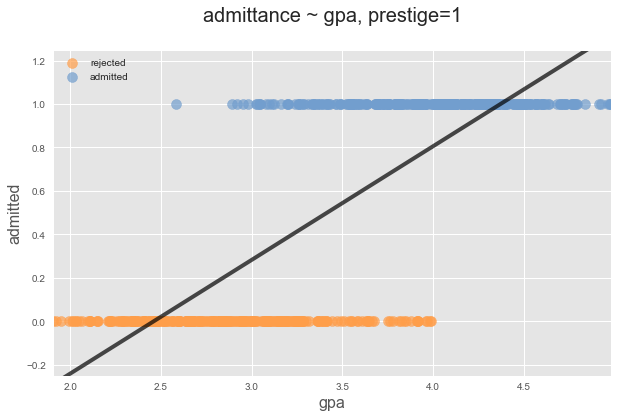

In [9]:
fig, ax = plt.subplots(figsize=(10,6))

x_vals = np.linspace(1.,5.,300)
ax.plot(x_vals, linmod.predict(x_vals[:, np.newaxis]),
        color='black', alpha=0.7, lw=4)

# do one scatter plot for each admission status:
ax.scatter(admit.gpa[admit.admit == 0],
           admit.admit[admit.admit == 0], c=colors['orange'], s=100, alpha=0.7, label='rejected')

ax.scatter(admit.gpa[admit.admit == 1], admit.admit[admit.admit == 1],
           c=colors['blue'], s=100, alpha=0.7, label='admitted')

ax.set_ylabel('admitted', fontsize=16)
ax.set_xlabel('gpa', fontsize=16)
ax.set_title('admittance ~ gpa, prestige=1\n', fontsize=20)
ax.set_xlim([admit['gpa'].min(),admit['gpa'].max()])
ax.set_ylim(-0.25, 1.25)
plt.legend(loc='upper left')


<a id='pred-binary'></a>

## Predicting a binary class

---

In our case we have two classes `1=admitted` and `0=rejected`.

The logistic regression is still solving for an expected value. In our binary classification case this expected value is the probability of `y` being one of the classes.

 $$E(y) = P(y = 1)$$

As you can see, we still represent this with a regression on the right side.

 $$E(y|X) = P(y = 1|X) = \beta_0 + \sum_{j}^p\beta_jx_j$$

> What problem do we have here?  What values can a probability take?

Probabilities have to be in the range [0, 1]. The right side of the equation is in no way bounded to [0, 1]. We need to *guarantee* that the right-hand side of the regression equation will evaluate to a probability estimate.

## The logit "link function"


We can restrict the value of the LHS using a  **link function**.

A link function is simply a function that we apply to constrain $y$ to a desired range.

$$\text{logit}(\;p\;) =  \beta_0 + \sum_{j}^p\beta_jx_j $$


So we're looking for some function that will restrict the p to [0,1].  So $\text{logit}(\;p\;)$ must be in the range [-inf,+inf], and $p$ in the range [0,1].

### So what's the logit link?  First... odds ratios...

The initial step in the logit link function involves the use of **odds ratios**. Before we get into _why_, it's important to understand what an odds ratio is.

Probabilities and odds ratios represent the same thing in different ways. Probabilities can be alternatively expressed as odds ratios. The odds ratio for probability **p** is defined:

 $$\text{odds ratio}(p) = \frac{p}{1-p}$$

The odds ratio of a probability is a measure of how many times more likely it is than the inverse case.

For example:

- When **`p = 0.5`**: **`odds ratio = 1`**
    - it is equally likely to happen as it is to not happen.
- When **`p = 0.75`**: **`odds ratio = 3`**
    - it is 3 times more likely to happen than not happen.
- When **`p = 0.40`**: **`odds ratio = 0.666..`**
    - it is 2/3rds as likely to happen than not happen.

### Let's see some examples:

#### What are the probabilities of admission by prestige?

In [10]:
y_p1 = admissions[admissions.prestige == 1].admit.values
y_p2 = admissions[admissions.prestige == 2].admit.values
y_p3 = admissions[admissions.prestige == 3].admit.values
y_p4 = admissions[admissions.prestige == 4].admit.values

In [11]:
print 'P(admit | prestige = 1):', np.mean(y_p1)
print 'P(admit | prestige = 2):', np.mean(y_p2)
print 'P(admit | prestige = 3):', np.mean(y_p3)
print 'P(admit | prestige = 4):', np.mean(y_p4)

P(admit | prestige = 1): 0.540983606557
P(admit | prestige = 2): 0.358108108108
P(admit | prestige = 3): 0.231404958678
P(admit | prestige = 4): 0.179104477612


#### Write a function to calculate odds ratios and calculate the odds ratios of admittance by prestige.

In [12]:
def odds_ratio(p):
    return (float(p) / (1 - p))

### Let's calculate a few....

What are the correct interpretation of the below?

In [13]:
print 'odds(admit | prestige = 1):', odds_ratio(np.mean(y_p1))
print 'odds(admit | prestige = 2):', odds_ratio(np.mean(y_p2))
print 'odds(admit | prestige = 3):', odds_ratio(np.mean(y_p3))
print 'odds(admit | prestige = 4):', odds_ratio(np.mean(y_p4))

odds(admit | prestige = 1): 1.17857142857
odds(admit | prestige = 2): 0.557894736842
odds(admit | prestige = 3): 0.301075268817
odds(admit | prestige = 4): 0.218181818182


### So what happens if we were to use the odds ratio in place of y?

Remeber that we are trying to satisfy two conditions:
1. Our estimate of p must represent a probability in some way (so must be in [0,1]).
2. The regression formula pre-transformation (RHS) must be able to evaluate to anything on the real number range.

We can start by putting the odds ratio in place of the probability on the left side of the regression equation:

$$ \frac{P(y = 1)}{1-P(y = 1)} = \beta_0 + \sum_{j}^p\beta_jx_j$$

The range of odds ratio, our predicted value, is now restricted to be in the range **`[0, infinity]`**


## What happens if we just leave it like this?

Remember that the RHS can evaluate to [-inf, inf].  So we need to modify our LHS further such that it can take values down to -infinity.

<a id='log-odds'></a>

### Step 2: the log-odds (natural logarithm of the odds ratio) instead of the odds ratio

If we take the natural logarithm of a variable that falls between 0 and infinity, we can transform it into a variable that falls in the range [-inf, inf].

>Check this for yourself!  What is the natural log of a number in the range [0,1]?  
>How about [1, inf]?  
> And 1 exactly?



The formula now works: the regression can now predict any negative or positive number, and we can convert it back into the odds ratio, and then a probability in the range [0,1].

The combination of converting the probability to an odds ratio and taking the logarithm of that is called the **logit link function**:

 $$\text{logit}\big(y\big) = ln\bigg(\frac{P(y=1)}{1-P(y=1)}\bigg) =  \beta_0 + \sum_{j}^p\beta_jx_j$$

## Ok great... but how do I get the probability out?


The inverse function of the logit is called the **logistic function** (also sigmoid function). 



$$P(y=1) = \frac{e^{\left(\beta_0 + \sum_{j}^p\beta_jx_j\right)}}{e^{\left(\beta_0 + \sum_{j}^p\beta_jx_j\right)}+1}$$

> Let's prove this to ourselves with algebra

![text](https://media.giphy.com/media/12RfP2odT4hEOI/giphy.gif)




<a id='logistic-viz'></a>

## The logistic regression prediction line visually

---

Let's plot the prediction of `admit` using sklearn's `LogisticRegression` class and see what the regression line looks like.

In [14]:
# we'll use sklearn to find the estimated for betas
y = admit.admit.values
X = admit[['gpa']].values

logreg = LogisticRegression()
logreg.fit(X, y)

print 'Logreg intercept:', logreg.intercept_
print 'Logreg coef(s):', logreg.coef_

Logreg intercept: [-8.44152473]
Logreg coef(s): [[ 2.51391997]]


In [15]:
def calc_prob(intercept, coef, x):
    '''calculates the probabilty of y=1 for given intercept and beta_1'''
    return (np.exp(intercept + coef*x) / (1 + np.exp(intercept + coef*x)))[0][0]


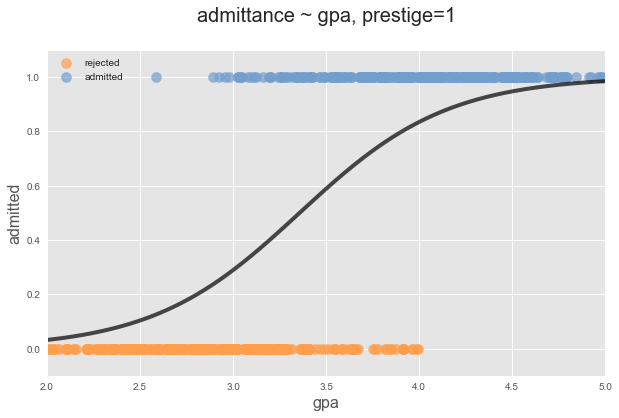

In [16]:
fig, ax = plt.subplots(figsize=(10,6))

# plot the logreg regression line for admit ~ gpa
x_vals = np.linspace(2.,5.,300)
y_pp = [calc_prob(logreg.intercept_, logreg.coef_,x) for x in x_vals]
ax.plot(x_vals, y_pp, color='black', alpha=0.7, lw=4)

ax.scatter(admit.gpa[admit.admit == 0],
           admit.admit[admit.admit == 0],
           c=colors['orange'], s=100, alpha=0.7,
           label='rejected')

ax.scatter(admit.gpa[admit.admit == 1],
           admit.admit[admit.admit == 1],
           c=colors['blue'], s=100, alpha=0.7,
           label='admitted')


ax.set_ylabel('admitted', fontsize=16)
ax.set_xlabel('gpa', fontsize=16)
ax.set_title('admittance ~ gpa, prestige=1\n', fontsize=20)

ax.set_xlim([2.,5.])
ax.set_ylim([-0.1, 1.1])

plt.legend(loc='upper left')
plt.show()

<a id='solving-beta'></a>
## Solving for the beta coefficients

---

Logistic regression minimizes the "deviance", which is analagous to the residual sum of squares in linear regression. There is not a closed-form solution to the beta coefficients like in linear regression, and the betas are found through optimization procedures.

If you are particularly interested in the math, these two resources are good:

[A good blog post on the logistic regression beta coefficient derivation.](http://www.win-vector.com/blog/2011/09/the-simpler-derivation-of-logistic-regression/)

[This paper is also a good reference.](https://www.stat.cmu.edu/~cshalizi/402/lectures/14-logistic-regression/lecture-14.pdf)



## Interpreting logistic regression coefficients

The interpretation of logistic regression coefficients can be a little confusing due to the logistic function.

Let's work through an example with this dataset.  

We're going to use statsmodel because it shows us the nice interface with summary!



In [17]:
import statsmodels.api as sm

df = admissions.copy()
df.head()

,admit,gre,gpa,prestige
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0


In [18]:
dummy_ranks = pd.get_dummies(df["prestige"], prefix="prestige")
dummy_ranks.head()

,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1


In [19]:
cols_to_keep = ["admit", "gre", "gpa"]
data = df[cols_to_keep].join(dummy_ranks).drop('prestige_4.0', axis=1)
data.head()

,admit,gre,gpa,prestige_1.0,prestige_2.0,prestige_3.0
0,0,380.0,3.61,0,0,1
1,1,660.0,3.67,0,0,1
2,1,800.0,4.00,1,0,0
3,1,640.0,3.19,0,0,0
4,0,520.0,2.93,0,0,0


In [20]:
# stats models has no intercept by default
data["intercept"] = 1.0
train_cols = data.columns[1:]

In [21]:
logit = sm.Logit(data["admit"], data[train_cols])

In [22]:
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.573854
         Iterations 6


In [23]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.082     
Dependent Variable: admit            AIC:              467.6399  
Date:               2017-07-27 15:06 BIC:              491.5435  
No. Observations:   397              Log-Likelihood:   -227.82   
Df Model:           5                LL-Null:          -248.08   
Df Residuals:       391              LLR p-value:      1.1761e-07
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
gre            0.0022    0.0011   2.0280  0.0426   0.0001   0.0044
gpa            0.7793    0.3325   2.3438  0.0191   0.1276   1.4311
prestige_1.0   1.5534    0.4175   3.7211  0.0002   0.7352   2.3716
prestige_2.0   0.8733    0.3673   2.3777  0.0174   0.1534   1.5931
prestige_3.0   0.2147    0.3926   0.5470  0.5844  -0.5547   0.9841
intercept     -5.4303    1.1399  -4.7639  0.0000  -7.6644  -3.1962
=================================================================

"""

## What are the interpretations of these coefficients?

- For every one unit change in gre, the log odds of admission (versus non-admission) increases by 0.002.
- For a one unit increase in gpa, the log odds of being admitted to graduate school increases by 0.804.
- The coefficients for the categories of rank have a slightly different interpretation. Remember that we dropped prestige 4, so this is our reference case.
    - For example, having attended an undergraduate institution with a rank of 1, versus an institution with a rank of 4, increases the log odds of admission by 1.55. 

## Ugh.  But I hate log-odds.  Can I get odds?

Yes.

So for a one unit increase in gpa, we get e^0.7793 = 2.18 or 118% increase in the odds of acceptance.

## ... but didn't we say that logistic regression is used for classification?

How can we convert our probabilities into classes?  I.e., what if I want to predict admit vs not?  How can I use the estimated probabilities to do this?

## Conclusion


The goal of logistic regression is to find the best fitting model to describe the relationship between the characteristic of interest (dependent variable = response or outcome variable) and a set of independent (predictor or explanatory) variables. 

Logistic regression generates the coefficients (and in statsmodels the standard errors and significance levels) of a formula to predict a logit transformation of the probability of presence of the characteristic of interest.

**Benefits of Logistic regression include:**
- Logistic regression is a classification algorithm that shares similar properties to linear regression
- It is very fast and efficient and is by far the most common classification algorithm
- The coefficients in a logistic regression model are interpretable (albeit somewhat complex): they represent the change in log-odds due to the input variables

##  Independent Practice

For the independent practice, you are going to repeat the above regression in sklearn.  

<a id='resources'></a>

## Additional resources

---

- [Logistic Regression Video Walkthrough](https://www.youtube.com/watch?v=zAULhNrnuL4&noredirect=1)
- [Logistic Regression Walkthrough](http://www.mc.vanderbilt.edu/gcrc/workshop_files/2004-11-12.pdf)
- [Logistic Regression w/ Statsmodel - Well Switching in Bangledesh](http://nbviewer.ipython.org/urls/raw.github.com/carljv/Will_it_Python/master/ARM/ch5/arsenic_wells_switching.ipynb)
- [Odds Ratio Explanation](http://www.wright.edu/~thaddeus.tarpey/ES714glm.pdf)
- [0 and 1 are not probabilities](http://lesswrong.com/lw/mp/0_and_1_are_not_probabilities/)